## Homework 4

Use this notebook as a starter

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-09-27 12:30:24--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178,21K  --.-KB/s    in 0,07s   

2021-09-27 12:30:25 (2,47 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [17]:
df = pd.read_csv('data/CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head()

status  seniority  home  time  age  marital  records  job  expenses  \
0       1          9     1    60   30        2        1    3        73   
1       1         17     1    60   58        3        1    1        48   
2       2         10     2    36   46        2        2    3        90   
3       1          0     1    60   24        1        1    1        63   
4       1          0     1    36   26        1        1    1        46   

   income  assets  debt  amount  price  
0     129       0     0     800    846  
1     131       0     0    1000   1658  
2     200    3000     0    2000   2985  
3     182    2500     0     900   1325  
4     107       0     0     310    910

Some of the features are encoded as numbers. Use the following code to de-code them:

In [18]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [19]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [20]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [21]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [22]:
cols = ['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
        'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']
numericals = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']
categorical = ['home', 'marital', 'records', 'job', 'default']
df.shape

(4454, 14)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [23]:
X = df.copy()
X_full_train, X_test = train_test_split(X, test_size=0.20, random_state=1)
X_train, X_val = train_test_split(X_full_train, test_size=0.25, random_state=1)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_full_train = X_full_train.reset_index(drop=True)

y_train = X_train.default.values
y_val = X_val.default.values
y_test = X_test.default.values

if 'default' in X_train:
    del X_train['default']
if 'default' in X_val:
    del X_val['default']
if 'default' in X_test:
    del X_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [24]:
print('Seniority: ', roc_auc_score(y_train, X_train.seniority))
print('Time: ', roc_auc_score(y_train, X_train.time))
print('Income: ', roc_auc_score(y_train, X_train.income))
print('Debt: ', roc_auc_score(y_train, X_train.debt))

Seniority:  0.2906221375508058
Time:  0.5608662489595051
Income:  0.31799333386736695
Debt:  0.49521703242164505


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [25]:
cols_to_use = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv = DictVectorizer(sparse=False)
train_dict = X_train[cols_to_use].to_dict(orient='records')
X_train_dict = dv.fit_transform(train_dict)

val_dict = X_val[cols_to_use].to_dict(orient='records')
X_val_dict = dv.transform(val_dict)

In [26]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dict, y_train)
y_pred = model.predict_proba(X_val_dict)[:, 1]

In [27]:
auc_score = roc_auc_score(y_val, y_pred)
print('auc score: ', round(auc_score, 3))
# Answer 0.812

auc score:  0.812


In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

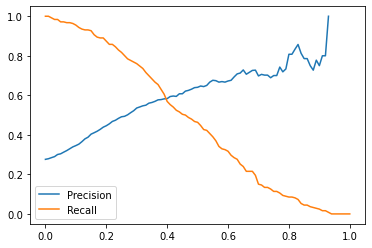

In [29]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

# df_scores
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()
# Answer 0.4

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [31]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores[df_scores['F1'] == df_scores['F1'].max()]
# Answer = 0.3

threshold   tp   fp  fn   tn       tpr       fpr  precision    recall  \
30        0.3  187  162  59  483  0.760163  0.251163   0.535817  0.760163   

          F1  
30  0.628571

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [32]:
n_splits = 5
folds = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]


def kfolds(n_splits, folds, fixed_c):
    for f in folds:
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

        scores = []

        for train_idx, val_idx in kfold.split(X_full_train):
            df_train = X_full_train.iloc[train_idx]
            df_val = X_full_train.iloc[val_idx]

            y_train = df_train.default.values
            y_val = df_val.default.values

            # Train
            dicts_train = df_train[cols_to_use].to_dict(orient='records')
            dv = DictVectorizer(sparse=False)
            X_train = dv.fit_transform(dicts_train)
            if fixed_c == True:
                model = LogisticRegression(solver='liblinear', C=1, max_iter=1000)
            else:
                model = LogisticRegression(solver='liblinear', C=f, max_iter=1000)
            model.fit(X_train, y_train)

            # Predict
            dicts_val = df_val[cols_to_use].to_dict(orient='records')
            X = dv.transform(dicts_val)
            y_pred = model.predict_proba(X)[:, 1]

            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        print('C=%s %.3f +- %.3f' % (f, np.mean(scores), np.std(scores)))
    return scores


scores = kfolds(n_splits, folds, fixed_c=True)
round(np.array(scores).std(), 3)

C=0.001 0.814 +- 0.015
C=0.01 0.814 +- 0.015
C=0.1 0.814 +- 0.015
C=0.5 0.814 +- 0.015
C=1 0.814 +- 0.015
C=5 0.814 +- 0.015
C=10 0.814 +- 0.015


0.015

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round to three digits)

In [33]:
folds = [0.01, 0.1, 1, 10]
scores = kfolds(n_splits, folds, fixed_c=False)
# Answer = 1

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.